In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import cobra
import pickle
from scipy.integrate import solve_ivp
from finitediff import interpolate_by_finite_diff
import snek

ecoli = cobra.io.read_sbml_model('../models/iML1515_pDNA.xml')
ecoli.solver = 'cplex'

# Experimental Data

In [14]:
df = pd.read_csv("../results/extended_experimental_data.csv",index_col=0)

In [15]:
ctrl = df[df['Information'] == 'lin_ctrl']
slim = df[df['Information'] == 'lin_slim']
m_slim = df[df['Information']=='lin_slim_mean']
m_ctrl = df[df['Information']=='lin_ctrl_mean']

In [16]:
def trim_violinplot(v,side,color):
    for b in v['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        if side == "l":
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
        else:
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        # if color == "red" or color == "r":
        #     color = "#ffb2b3"
        # elif color == "black" or color == "k":
        #     color = "#b2b2b2"
        b.set_color(color)
        b.set_edgecolor(color)
        b.set_linewidth(0)
        b.set_alpha(.4)

# Figure 5

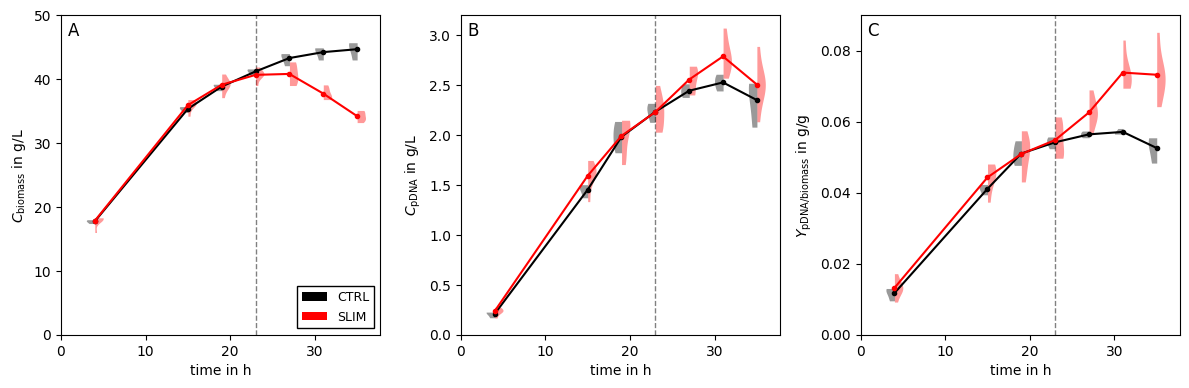

In [17]:
fig = plt.figure(dpi=100,figsize=(12,4))
fig.set_facecolor('w')
ax1 = fig.add_subplot(131,box_aspect=1)
ax2 = fig.add_subplot(132,box_aspect=1)
ax3 = fig.add_subplot(133,box_aspect=1)
for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('time in h')


ax1.bar(0,0,label='CTRL',color='k')
ax1.bar(0,0,label=r'SLIM',color='r')
ax1.legend(edgecolor='k',fancybox=False,loc='lower right',framealpha=1,fontsize=9)

points = [ctrl,slim]
lines  = [m_ctrl,m_slim]
colors = ['k','r']
marker = ['.','x']
offset = ["l","r"]
violin = []

for i in range(2):
    # ax1
    v1 = ax1.violinplot([i for i in np.reshape(points[i]['X[g]'].values/points[i]['V[L]'].values,(7,-1),order="F")], 
                        positions=np.reshape(points[i]['t[h]'].values,(7,-1),order="F")[:,0],
                        widths=2,
                        showmeans=False, showextrema=False, showmedians=False)
    ax1.plot(lines[i]['t[h]'],
             lines[i]['X[g]']/lines[i]['V[L]'],
             color=colors[i],
             zorder=2,marker=".")
    # ax2
    v2 = ax2.violinplot([i for i in np.reshape(points[i]['P[g]'].values/points[i]['V[L]'].values,(7,-1),order="F")], 
                        positions=np.reshape(points[i]['t[h]'].values,(7,-1),order="F")[:,0],
                        widths=2,
                        showmeans=False, showextrema=False, showmedians=False)
    ax2.plot(lines[i]['t[h]'],
             lines[i]['P[g]']/lines[i]['V[L]'],
             color=colors[i],
             zorder=2,marker=".")
    # ax3
    ax3.plot(lines[i]['t[h]'],
             lines[i]['P[g]']/lines[i]['X[g]'],
             color=colors[i],
             zorder=2,marker=".")
    v3 = ax3.violinplot([i for i in np.reshape(points[i]['P[g]'].values/points[i]['X[g]'].values,(7,-1),order="F")], 
                        positions=np.reshape(points[i]['t[h]'].values,(7,-1),order="F")[:,0],
                        widths=2,
                        showmeans=False, showextrema=False, showmedians=False)
    for v in [v1,v2,v3]:
        trim_violinplot(v,offset[i],colors[i])

    
labels = [r'$C_{\rm biomass}$ in g/L',
          r'$C_{\rm pDNA}$ in g/L',
          r'$Y_{\rm pDNA/biomass}$ in g/g',
         ]

for j,ax in enumerate([ax1,ax2,ax3]):
    ax.set_xlim(0, 37.76)
    ax.set_ylabel(labels[j])
    t_star = 23
    ax.axvline(t_star,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax1.set_ylim(0,50)
ax2.set_ylim(0,3.2)
ax3.set_ylim(0,.09)
ax3.set_yticks([0,.02,.04,.06,.08])

import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E',],[ax1,ax2,ax3]):
#     ax.set_title(name, loc='left', pad=-200)
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()
plt.show()

# Figure 6

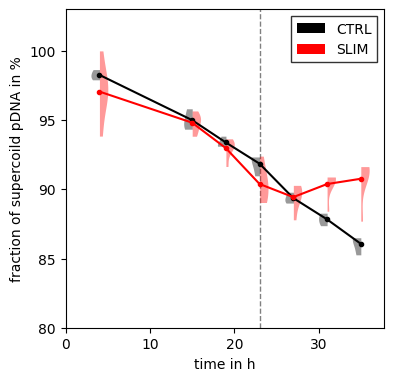

In [18]:
fig = plt.figure(dpi=100,figsize=(4,4))
fig.set_facecolor('w')
ax1 = fig.add_subplot(111,box_aspect=1)

plt.plot(m_ctrl['t[h]'],m_ctrl['ccc[%]'],color='k',marker=".")
v1 = plt.violinplot([i for i in np.reshape(ctrl['ccc[%]'].values,(7,-1),order="F")], 
                    positions=np.reshape(ctrl['t[h]'].values,(7,-1),order="F")[:,0],
                    widths=2,
                    showmeans=False, showextrema=False, showmedians=False)
trim_violinplot(v1,"l","k")

plt.plot(m_slim['t[h]'],m_slim['ccc[%]'],color='red',marker=".")
v1 = plt.violinplot([i for i in np.reshape(slim['ccc[%]'].values,(7,-1),order="F")], 
                    positions=np.reshape(slim['t[h]'].values,(7,-1),order="F")[:,0],
                    widths=2,
                    showmeans=False, showextrema=False, showmedians=False)
trim_violinplot(v1,"r","r")


ax1.bar(0,0,label='CTRL',color='k')
ax1.bar(0,0,label=r'SLIM',color='r')

ax1.axvline(23,zorder=-1,color='grey',linestyle='--',linewidth=1)

plt.ylim(80,103)
ax1.set_xlim(0, 37.76)
plt.legend()
plt.xlabel('time in h')
plt.ylabel('fraction of supercoild pDNA in %')

plt.tight_layout()
plt.show()

# Figure 7

In [19]:
with open('../preprocessing/220829_dFBA_lin_feed_v04.pkl','rb') as file:
    lin_processed,lin_special_interest = pickle.load(file)
q_pDNA_max_levels = list(lin_processed.keys())
print(np.array(q_pDNA_max_levels))
q_pDNA_min = .1/100
del file

[0.001  0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019
 0.002  0.0021 0.0022 0.0023 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029
 0.003  0.0031 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039
 0.004  0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049
 0.005 ]


In [20]:
from finitediff import derivatives_at_point_by_finite_diff, interpolate_by_finite_diff

def calculate_diffs(df,yfactor=1):
    x_fit  = df['t[h]'].values
    nhead = 1
    ntail = 1
    X = df['X[g]'].values
    P = df['P[g]'].values
    t = df['t[h]'].values
    x_data = t
    y_data = P
    interp = interpolate_by_finite_diff(x_data, y_data, x_fit, 1, nhead, ntail)
    dydx_fit = interp[:, 0]/X
    dydx_fit = interp[:, 1]/X
    return x_fit,dydx_fit*yfactor

## fit non-constant qP

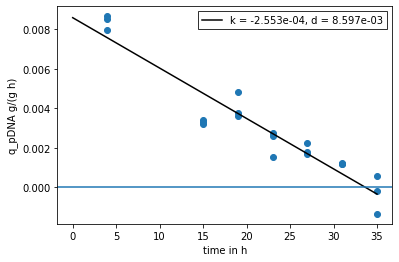

In [21]:
from scipy.optimize import minimize

def fun_to_min(theta):
    k,d = theta
    fit_q = all_t_vals*k+d
    sse = np.sum(np.abs(fit_q-all_q_vals)**2)
    return sse

all_t_vals = np.array([])
all_q_vals = np.array([])
for experiment in ctrl['Experiment'].unique():
    tmp = ctrl[ctrl['Experiment']==experiment]
    t_vals, q_vals = calculate_diffs(tmp)
    all_t_vals = np.append(all_t_vals,t_vals)
    all_q_vals = np.append(all_q_vals,q_vals)

sol = minimize(fun_to_min,(1,1))    

t = np.linspace(0,35,100)
q = sol.x[0]*t+sol.x[1]
plt.plot(t,q,color='k',label=f'k = {sol.x[0]:.3e}, d = {sol.x[1]:.3e}')
plt.scatter(all_t_vals,all_q_vals)
plt.axhline(0)
plt.ylabel('q_pDNA g/(g h)')
plt.xlabel('time in h')
plt.legend()
plt.show()

[0.00928714]


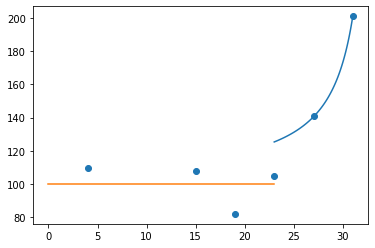

In [22]:
# calculate the average experimental kappa values

all_points = []
for experiment in ctrl['Experiment'].unique():
    tmp = ctrl[ctrl['Experiment']==experiment]
    t, q_ctrl = calculate_diffs(tmp)    
    for experiment in slim['Experiment'].unique():
        tmp = slim[slim['Experiment']==experiment]
        t, q_slim = calculate_diffs(tmp)
        all_points.append(q_slim[:-1]/q_ctrl[:-1]*100)
experimental_t = t[:-1]        
all_points = np.array(all_points)
all_m_points = np.mean(all_points,axis=0)

# fit line through q_pDNA and minimize kappa
def calc_kappa_vals(t,k,dslim,dctrl):
    qctrl = t*k+dctrl
    qslim = t*k+dslim
    return qslim/qctrl*100
    
def fun_to_min(dslim):
    kappa = calc_kappa_vals(experimental_t[-2:],-2.553e-4,dslim,8.597e-3)
    SSE = np.sum((all_m_points[-2:]-kappa)**2)
    return SSE

sol = minimize(fun_to_min,1e-3)
print(sol.x)

# plot experiment an fitted points
fit_t = np.linspace(23,31,101)
kappa = calc_kappa_vals(fit_t,-2.553e-4,sol.x,8.597e-3)
plt.plot(fit_t,kappa)
plt.scatter(experimental_t,all_m_points)
plt.plot([0,23],[100,100])
plt.show()

## dFBA

In [23]:
from scipy.integrate import solve_ivp

def run_pFBA(_in):
    def infeasible_ATPM(t, y, model, tol, r_F_G, r_F_growth):
        '''
        Infeasibility event. Usually occures when the glucose uptake flux is smaller than the ATPM requirement.
        '''

        V,X,S,P,G,A = y  # expand the boundary species
        q_G = -r_F_G/X
        with model as tmpmodel:
            snek.set_bounds(tmpmodel,'EX_glc__D_e',lb=q_G,ub=q_G)
            if S <= tol:
                snek.set_bounds(tmpmodel,'EX_so4_e',lb=0)
            fluxes = np.array([])
            for reaction, direction in zip(['BIOMASS_Ec_iML1515_core_75p37M'],['max']):
                tmpmodel.objective = reaction
                tmpmodel.objective_direction = direction
                tmp = tmpmodel.slim_optimize()
                if np.isnan(tmp):
                    return 0
                else:
                    return 1
    infeasible_ATPM.terminal = False
    infeasible_ATPM.direction = 0

    def infeasible_V(t, y, model, tol, r_F_G, r_F_growth):
        '''
        Infeasibility event. Usually occures when the volume of the reactor is above 1.
        '''

        V,X,S,P,G,A = y  # expand the boundary species
        return 1-V
    infeasible_V.terminal = True
    infeasible_V.direction = 0

    def dFBA(t, y, model, tol, r_F_G, r_F_growth):
        """
        Calculate the time derivative of external species.
        """

        V,X,S,P,G,A = y  # expand the boundary species
        dV_dt = r_F_growth
        q_G = -r_F_G/X
        # Calculate the specific exchanges fluxes at the given external concentrations.
        with model as tmpmodel:
            snek.set_bounds(tmpmodel,'EX_glc__D_e',lb=q_G,ub=q_G)
            q_pdna_min = 8.597e-3 - t*2.553e-4 # g/(g h)
            q_pdna_min = q_pdna_min / ecoli.metabolites.pDNA_c.formula_weight * 1000 # g/(g h) * mol/g = mol/(g h)
            q_pdna_max = q_pdna_min    
            if S <= tol:
                snek.set_bounds(tmpmodel,'EX_so4_e',lb=0)
                # q_pdna_max = 9.406e-3 - t*2.553e-4 # g/(g h) first version
                q_pdna_max = 0.00928714 - t*2.553e-4 # g/(g h) better fit
                q_pdna_max = q_pdna_max / ecoli.metabolites.pDNA_c.formula_weight * 1000 # g/(g h) * mol/g = mol/(g h)
                if q_pdna_max < q_pdna_min:
                    #print(q_pdna_max-q_pdna_min)
                    q_pdna_max = q_pdna_min
            snek.set_bounds(tmpmodel,'pDNA_synthesis',lb=q_pdna_min,ub=q_pdna_max)
            fluxes = np.array([])
            for reaction, direction in zip(['BIOMASS_Ec_iML1515_core_75p37M','EX_so4_e','pDNA_synthesis','EX_glc__D_e',"EX_ac_e"],['max','max','max','min',"max"]):
                tmpmodel.objective = reaction
                tmpmodel.objective_direction = direction
                tmp = tmpmodel.slim_optimize()
                # the nan is excepted here but will trigger the terminal event.
                tmp = np.nan_to_num(tmp)
                fluxes = np.append(fluxes,tmp)
                snek.set_bounds(tmpmodel,reaction,tmp,tmp)
            del tmpmodel

        fluxes *= X
        return np.append(dV_dt,fluxes)
    
    S_0, ecoli = _in 
    ecoli.solver = 'cplex'
    ecoli.tolerance = 1e-8
    
    ts = np.linspace(0, 31, 10000)
    # feed rate
    r_F_growth = 13.9/1000 # L/h
    # glucose conc in feed
    G_F = 329.88 # g/L glucose
    # glucse feed rate
    r_F_G = r_F_growth*G_F # gG/h
    r_F_G = r_F_G / snek.elements.molecular_weight('C6H12O6') * 1000 # mmol G/h
    V_0 = .5    # L batch volume
    X_0 = 1.52  # g
    P_0 = 0     # mmol
    y0 = [V_0,X_0,S_0,P_0,0,0]
    tol = 1e-6
    sol = solve_ivp(
        fun=dFBA,
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        args = (ecoli,tol,r_F_G, r_F_growth),
        events= [infeasible_ATPM,infeasible_V],
        rtol=tol,
        atol=tol,
        method='RK45'
    )
    
    return [S_0, sol]

from finitediff import derivatives_at_point_by_finite_diff, interpolate_by_finite_diff

def calculate_diffs(df,yfactor=1):
    x_fit  = df['t[h]'].values
    nhead = 1
    ntail = 1
    X = df['X[g]'].values
    P = df['P[g]'].values
    t = df['t[h]'].values
    x_data = t
    y_data = P
    interp = interpolate_by_finite_diff(x_data, y_data, x_fit, 1, nhead, ntail)
    dydx_fit = interp[:, 0]/X
    dydx_fit = interp[:, 1]/X
    return x_fit,dydx_fit*yfactor
    
# CALCULATE dP/dt /X
x_fit  = m_ctrl['t[h]'].values
nhead = 1
ntail = 1

# SLIM
tmp = m_slim
X = tmp['X[g]'].values
P = tmp['P[g]'].values
t = tmp['t[h]'].values
x_data = t
y_data = P
interp_slim = interpolate_by_finite_diff(x_data, y_data, x_fit, 1, nhead, ntail)
y_fit_slim = interp_slim[:, 0]/X
dydx_fit_slim = interp_slim[:, 1]/X

tmp = m_ctrl
X = tmp['X[g]'].values
P = tmp['P[g]'].values
t = tmp['t[h]'].values
x_data = t
y_data = P #/X
interp_ctrl = interpolate_by_finite_diff(x_data, y_data, x_fit, 1, nhead, ntail)
y_fit_ctrl = interp_ctrl[:, 0]/X
dydx_fit_ctrl = interp_ctrl[:, 1]/X

In [24]:
# DO SIMULATIONS
q_pDNA_max  = q_pDNA_max_levels[5]
endpoints          = lin_processed[q_pDNA_max]
S_0_array          = endpoints[:,0] 
t_end_array        = endpoints[:,1]
t_star_start_array = endpoints[:,7]
t_star_len_array   = t_end_array - t_star_start_array
idx_ctrl = -1
idx_23h  = np.argmin(np.nan_to_num(np.abs(t_star_len_array-13),nan=1000))
S_0_ctrl = S_0_array[idx_ctrl]
S_0_23h  = S_0_array[idx_23h]

colors = ['k','r']
ratio = {}
sims = {}
labs = ["ctrl","slim"]
for nr, S_0 in enumerate([S_0_ctrl,S_0_23h]):
    with ecoli as tmp:
        S_0, sol = run_pFBA([S_0,tmp])
    del tmp
        
    S_0 = S_0 * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t   = sol.t                                                    # h
    V   = sol.y.T[:,0]
    X   = sol.y.T[:,1]/V                                                    # g
    S   = sol.y.T[:,2]/V * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P   = sol.y.T[:,3]/V * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G   = sol.y.T[:,4]/V * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    productivity = P/t
    ratio[labs[nr]] = productivity
    
    t   = sol.t                                                    # h
    V   = sol.y.T[:,0]
    X   = sol.y.T[:,1]                                                    # g
    S   = sol.y.T[:,2] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol -> g
    P   = sol.y.T[:,3] * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol -> g
    G   = sol.y.T[:,4] * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol -> g
    xdf = pd.DataFrame([t,X,P]).T
    xdf.columns = ["t[h]","X[g]","P[g]"]
    sims[labs[nr]] = [sol,calculate_diffs(xdf),xdf]

/tmp/ipykernel_1134864/1437219338.py:29: RuntimeWarning: invalid value encountered in true_divide
  productivity = P/t
/tmp/ipykernel_1134864/1437219338.py:29: RuntimeWarning: invalid value encountered in true_divide
  productivity = P/t


## Plot Data

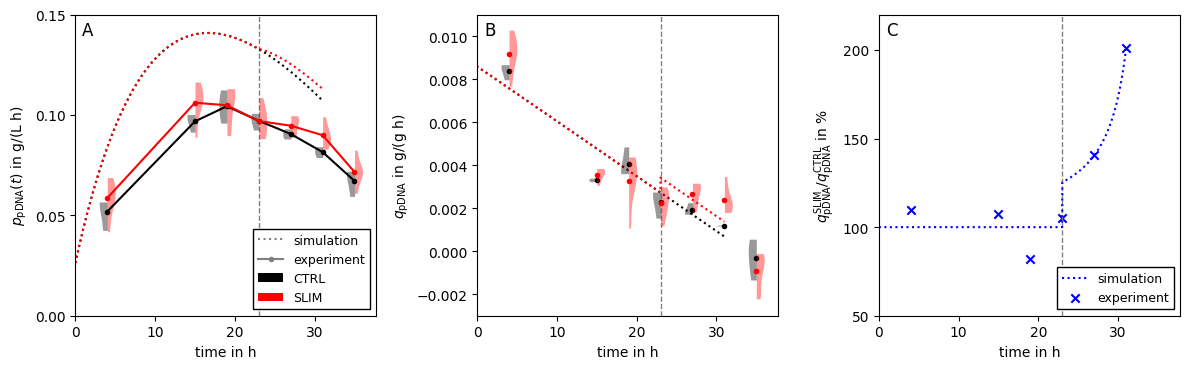

In [27]:
fig = plt.figure(dpi=100,figsize=(12,4))
fig.set_facecolor('w')
ax4 = fig.add_subplot(131,box_aspect=1)
ax5 = fig.add_subplot(132,box_aspect=1)
ax6 = fig.add_subplot(133,box_aspect=1)
offset = ["l","r"]

##################
# SUBPLOTS D,E,F #
##################

# SET UP LEGEND
from matplotlib.legend_handler import HandlerTuple

p3 = ax4.bar(0,0,label='control',color='k')
p4 = ax4.bar(0,0,label=r'SO$_4^{2-}$ limited',color='r')
p5 = ax4.bar(0,0,label=r'flux ratio',color='b')
p6,= ax4.plot(0,0,label='simulation',linestyle=':',color='grey')
p7,= ax4.plot(0,0,label='simulation',linestyle=':',color='b')
p1 = plt.scatter(-5,0,label='experiment',marker="x",color='b')
p2,= plt.plot(-5,0,label='experiment',marker=".",color='grey')
ax4.legend([p6,p2,p3,p4],
           ['simulation',"experiment","CTRL",r'SLIM',"flux ratio"],
           handler_map={tuple: HandlerTuple(ndivide=None)},
           edgecolor='k',fancybox=False,loc='lower right',framealpha=1,fontsize=9
          )
ax6.legend([p7,p1],
           ['simulation',"experiment","CTRL",r'SLIM',"flux ratio"],
           handler_map={tuple: HandlerTuple(ndivide=None)},
           edgecolor='k',fancybox=False,loc='lower right',framealpha=1,fontsize=9
          )

# PLOT SIMULATIONS AND EXPERIMENTS
colors = ['k','r']
labs = ["ctrl","slim"]
for nr, S_0 in enumerate([S_0_ctrl,S_0_23h]):
    xdf = sims[labs[nr]][2]
    ax4.plot(xdf["t[h]"],ratio[labs[nr]],color=colors[nr],linestyle=':')
    ax5.plot(*calculate_diffs(xdf),color=colors[nr],linestyle=':',zorder=-1)   
ax6.scatter(experimental_t,all_m_points,color='b',zorder=-4,marker="x")
ax6.plot(sims["ctrl"][1][0],sims["slim"][1][1]/sims["ctrl"][1][1]*100,color='b',linestyle=":")

points = [ctrl,slim]
lines  = [m_ctrl,m_slim]
colors = ['k','r']
marker = ['.','x']
for i in range(2):
    ax4.plot(lines[i]['t[h]'],
                lines[i]['P[g]']/lines[i]['V[L]']/lines[i]['t[h]'],
                color=colors[i],
                marker=".")
    v3 = ax4.violinplot([i for i in np.reshape(points[i]['P[g]'].values/points[i]['V[L]'].values/points[i]['t[h]'].values,(7,-1),order="F")], 
                        positions=np.reshape(points[i]['t[h]'].values,(7,-1),order="F")[:,0],
                        widths=2,
                        showmeans=False, showextrema=False, showmedians=False)
    trim_violinplot(v3,offset[i],colors[i])
    
    tmp_rates = []
    for experiment in points[i]['Experiment'].unique():
        tmp = points[i][points[i]['Experiment']==experiment]
        # ax5.scatter(*calculate_diffs(tmp),color=colors[i],marker=marker[i])
        tmp_diff = calculate_diffs(tmp)
        tmp_rates.append(tmp_diff[1])
    tmp_rates = np.array(tmp_rates)
    ax5.scatter(tmp_diff[0],np.mean(tmp_rates.swapaxes(0,1),axis=1),color=colors[i],marker=marker[0])
    v3 = ax5.violinplot([i for i in tmp_rates.swapaxes(0,1)], 
                        positions=tmp_diff[0],
                        widths=2,
                        showmeans=False, showextrema=False, showmedians=False)
    trim_violinplot(v3,offset[i],colors[i])

## FORMAT AXES
labels = [r'$p_{\rm pDNA}(t)$ in g/(L h)',
          r'$q_{\rm pDNA}$ in g/(g h)',
          r'$q_{\rm pDNA}^{\rm SLIM}/q_{\rm pDNA}^{\rm CTRL}$ in %'
         ]
for j,ax in enumerate([ax4,ax5,ax6]):
    ax.set_xlim(0, 37.76)
    ax.set_ylabel(labels[j])
    t_star = 23
    ax.axvline(t_star,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax4.set_yticks([0,.05,.1,.15])
ax4.set_ylim(0,.15)
ax5.set_ylim(-.003,.011)
ax6.set_ylim(50,220)
ax6.set_yticks([50,100,150,200])

for ax in [ax5,ax6,ax4]:
    ax.set_xlabel('time in h')

import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E','F'],[ax4,ax5,ax6]):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    
fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()
plt.show()

# Figure S6

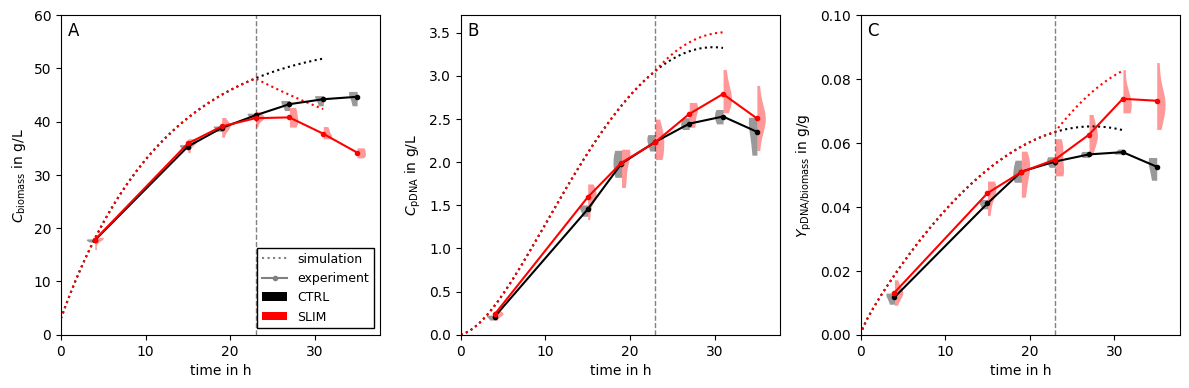

In [26]:
fig = plt.figure(dpi=100,figsize=(12,4))
fig.set_facecolor('w')
ax1 = fig.add_subplot(131,box_aspect=1)
ax2 = fig.add_subplot(132,box_aspect=1)
ax3 = fig.add_subplot(133,box_aspect=1)

##################
# SUBPLOTS D,E,F #
##################

# SET UP LEGEND
from matplotlib.legend_handler import HandlerTuple

p3 = ax4.bar(0,0,label='control',color='k')
p4 = ax4.bar(0,0,label=r'SO$_4^{2-}$ limited',color='r')
p5 = ax4.bar(0,0,label=r'flux ratio',color='b')
p6,= ax4.plot(0,0,label='simulation',linestyle=':',color='grey')
p7,= ax4.plot(0,0,label='simulation',linestyle=':',color='b')
p1 = plt.scatter(-5,0,label='experiment',marker="x",color='b')
p2,= plt.plot(-5,0,label='experiment',marker=".",color='grey')
ax1.legend([p6,p2,p3,p4],
           ['simulation',"experiment","CTRL",r'SLIM',"flux ratio"],
           handler_map={tuple: HandlerTuple(ndivide=None)},
           edgecolor='k',fancybox=False,loc='lower right',framealpha=1,fontsize=9
          )


for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('time in h')

    
##################
# SUBPLOTS A,B,C #
##################
    
labs = ["ctrl","slim"]
cols = ["k","r"]
for i in range(2):
    lab = labs[i]
    col = cols[i]
    sol = sims[lab][0]
    t   = sol.t                                                    # h
    V   = sol.y.T[:,0]
    X   = sol.y.T[:,1]/V                                                    # g
    S   = sol.y.T[:,2]/V * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P   = sol.y.T[:,3]/V * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G   = sol.y.T[:,4]/V * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    ax1.plot(t,X,color=col,linestyle=':')
    ax2.plot(t,P,color=col,linestyle=':')
    ax3.plot(t,P/X,color=col,linestyle=':')

points = [ctrl,slim]
lines  = [m_ctrl,m_slim]
colors = ['k','r']
marker = ['.','x']
for i in range(2):
    # ax1
    v1 = ax1.violinplot([i for i in np.reshape(points[i]['X[g]'].values/points[i]['V[L]'].values,(7,-1),order="F")], 
                        positions=np.reshape(points[i]['t[h]'].values,(7,-1),order="F")[:,0],
                        widths=2,
                        showmeans=False, showextrema=False, showmedians=False)
    ax1.plot(lines[i]['t[h]'],
             lines[i]['X[g]']/lines[i]['V[L]'],
             color=colors[i],
             zorder=2,marker=".")
    # ax2
    v2 = ax2.violinplot([i for i in np.reshape(points[i]['P[g]'].values/points[i]['V[L]'].values,(7,-1),order="F")], 
                        positions=np.reshape(points[i]['t[h]'].values,(7,-1),order="F")[:,0],
                        widths=2,
                        showmeans=False, showextrema=False, showmedians=False)
    ax2.plot(lines[i]['t[h]'],
             lines[i]['P[g]']/lines[i]['V[L]'],
             color=colors[i],
             zorder=2,marker=".")
    # ax3
    ax3.plot(lines[i]['t[h]'],
             lines[i]['P[g]']/lines[i]['X[g]'],
             color=colors[i],
             zorder=2,marker=".")
    v3 = ax3.violinplot([i for i in np.reshape(points[i]['P[g]'].values/points[i]['X[g]'].values,(7,-1),order="F")], 
                        positions=np.reshape(points[i]['t[h]'].values,(7,-1),order="F")[:,0],
                        widths=2,
                        showmeans=False, showextrema=False, showmedians=False)
    for v in [v1,v2,v3]:
        trim_violinplot(v,offset[i],colors[i])
    
labels = [r'$C_{\rm biomass}$ in g/L',
          r'$C_{\rm pDNA}$ in g/L',
          r'$Y_{\rm pDNA/biomass}$ in g/g',
         ]

for j,ax in enumerate([ax1,ax2,ax3]):
    ax.set_xlim(0, 37.76)
    ax.set_ylabel(labels[j])
    t_star = 23
    ax.axvline(t_star,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax1.set_ylim(0,60)
ax2.set_ylim(0,3.7)
ax3.set_ylim(0,.1)

import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E','F'],[ax1,ax2,ax3,ax4,ax5,ax6]):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    
fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()
plt.show()

# Figure S5

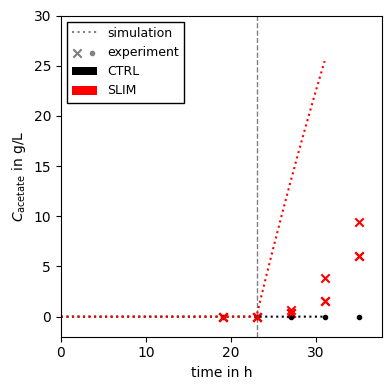

In [35]:
fig = plt.figure(dpi=100,figsize=(5,4))
fig.set_facecolor('w')
ax1 = fig.add_subplot(111,box_aspect=1)
ax1.set_box_aspect(1)
ax1.set_xlabel('time in h')
ax1.set_xlim(0,37.76)
ax1.set_ylim(-2,30)

p3 = ax1.bar(0,0,label='control',color='k')
p4 = ax1.bar(0,0,label=r'SO$_4^{2-}$ limited',color='r')
p5 = ax1.bar(0,0,label=r'flux ratio',color='b')
p6,= ax1.plot(0,0,label='simulation',linestyle=':',color='grey')
p1 = plt.scatter(-5,0,label='experiment',marker="x",color='grey')
p2 = plt.scatter(-5,0,label='experiment',marker=".",color='grey')
ax1.legend([p6,(p1,p2),p3,p4],
           ['simulation',"experiment","CTRL",r'SLIM',"flux ratio"],
           handler_map={tuple: HandlerTuple(ndivide=None)},
           edgecolor='k',fancybox=False,loc='upper left',framealpha=1,fontsize=9
          )

colors = ['k','r']
labs  = ["ctrl","slim"]
for nr, S_0 in enumerate([S_0_ctrl,S_0_23h]):
    sol = sims[labs[nr]][0]
    S_0 = S_0 * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    t   = sol.t                                                    # h
    V   = sol.y.T[:,0]
    X   = sol.y.T[:,1]/V                                                    # g
    S   = sol.y.T[:,2]/V * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P   = sol.y.T[:,3]/V * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G   = sol.y.T[:,4]/V * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    A   = sol.y.T[:,5]/V * ecoli.metabolites.ac_e.formula_weight / 1000 # mmol/L -> g/L
    ratio[S_0] = productivity
    ax1.plot(t,A,linestyle=':',color=colors[nr])

# points
for experiment in ctrl['Experiment'].unique():
    tmp = ctrl[ctrl['Experiment']==experiment]
    ax1.scatter(tmp["t[h]"],tmp["Acetate[mg/L]"]/1000,color='k',marker='.')
    
for experiment in slim['Experiment'].unique():
    tmp = slim[slim['Experiment']==experiment]
    ax1.scatter(tmp["t[h]"],tmp["Acetate[mg/L]"]/1000,color='r',marker='x')
    
t_star = 23
ax1.axvline(t_star,zorder=-1,color='grey',linestyle='--',linewidth=1)
ax1.set_ylabel(r"$C_{\rm acetate}$ in g/L")
    
fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()
plt.show()

# Figure S7

In [31]:
with open('../preprocessing/230717_dFBA_lin_feed_v06.pkl','rb') as file:
    combined_results = pickle.load(file)
q_pDNA_max_levels = list(combined_results.keys())
print(np.array(q_pDNA_max_levels))
q_pDNA_min = .1/100
del file

[0]


(0.0034873595163732295, 0.11823055440205843) (-0.1440939, 3.0259719)


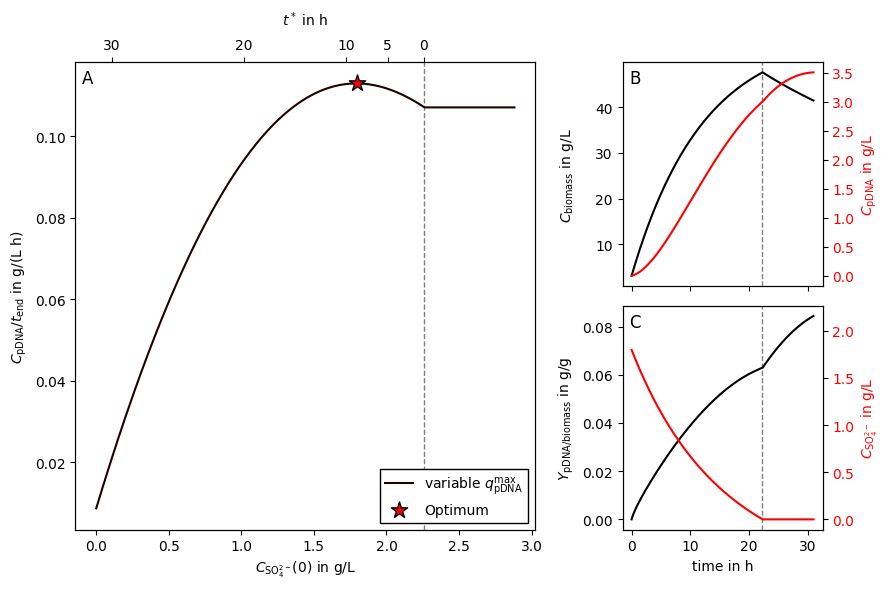

In [34]:
fig = plt.figure(dpi=100,figsize=(9,6))
fig.set_facecolor('w')
gs = fig.add_gridspec(nrows=4, ncols=2, width_ratios=[2.3,1], height_ratios=[1,.2,1,.2])
ax1 = fig.add_subplot(gs[0:,0])
ax2 = fig.add_subplot(gs[0:2,1])
ax3 = fig.add_subplot(gs[2: ,1])
ax1v2 = ax1.twiny()
ax2v2 = ax2.twinx()
ax3v2 = ax3.twinx()

#### AX1 ####

tol = 1e-8
colors = ['#200001','#825051','#cb8b85','#e1d3ab','#f7f7e6']
optima_x = []
optima_y = []
l = 0
max_star_time = 100
for q_pDNA_max in q_pDNA_max_levels:
    results = combined_results[q_pDNA_max]
    S_0_list = []
    P_end_list = []
    t_star_start_list = []
    for S_0 in sorted(results):
        sol = results[S_0]
        t = sol.t
        V = sol.y.T[:,0]
        X = sol.y.T[:,1]
        S = sol.y.T[:,2] * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
        P = sol.y.T[:,3] * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
        G = sol.y.T[:,4] * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
        # P/t
        P_over_t = P/V /(t+tol) # mmol/(L h)

        # find t_starvation_start
        s_is_0 = np.isclose(S,0,atol=1e-4)
        if np.any(s_is_0):
            idx_star_start = np.where(s_is_0)[0][0]          # index of t_starvation_start
            t_star_start   = t[idx_star_start]               # value of t_starvation_start
            t_star_end     = np.min([t[-1],t_star_start + max_star_time])    # value of t_starvation_end
            idx_star_end   = np.argmin(np.abs(t-t_star_end)) # index of t_starvation_end
            terminal_idx   = idx_star_end
        else:
            terminal_idx   = -1

        P_end_list.append(P_over_t[terminal_idx])
        t_star_start_list.append(t[terminal_idx]-t_star_start)
        S_0_list.append(S_0* ecoli.metabolites.so4_e.formula_weight / 1000/.5)

    if np.any([np.isclose(i,q_pDNA_max) for i in [0]]):
        ax1.plot(S_0_list,P_end_list,
                 color=colors[l], # cm.pink(q_pDNA_max/q_pDNA_min/5),
                 label=r'variable $q_{\rm pDNA}^{\rm max}$')
        l += 1
    optima_x.append(S_0_list[np.argmax(P_end_list)])
    if q_pDNA_max == 0:
        idx_optimum_zero_q_pDNA = np.argmax(P_end_list)
    optima_y.append(np.max(P_end_list))
    
cutoff_idx = len(optima_x) # -1
ax1.scatter(optima_x[:cutoff_idx],optima_y[:cutoff_idx],zorder=5,color='red',label='Optimum',marker="*",edgecolor="k",s=150)
ylim = ax1.get_ylim()
t_star = optima_x[0]
ax1.set_ylim(ylim)

# second X-axis
int_t_star_start = np.arange(int(np.min(t_star_start_list)),int(np.max(t_star_start_list)))
reduced_int_t_star_start = int_t_star_start[::int(len(int_t_star_start)/6)]
ax1_x2ticks = []
ax1_x2ticklabels = []
for i in np.array([30,20,10,5,0]): #reduced_int_t_star_start
    idx = np.argmin(np.abs(t_star_start_list-i))
    if i == 0:
        ax1.plot([S_0_list[idx]]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
    ax1_x2ticks.append(S_0_list[idx])
    ax1_x2ticklabels.append(i)
ax1_x2ticklabels = ['30','20','10','5','0']
ax1v2.set_xticks(ax1_x2ticks)
ax1v2.set_xticklabels(ax1_x2ticklabels)
ax1v2.set_xlim(ax1.get_xlim())

ax1v2.set_xlabel(r'$t^*$ in h',labelpad=10)
ax1.set_xlabel(r'$C_{\rm SO_4^{2-}}(0)$ in g/L')
ax1.set_ylabel(r'$C_{\rm pDNA}/t_{\rm end}$ in g/(L h)')
ax1.legend(fancybox=False,edgecolor='k',loc='lower right',framealpha=1)
fig.tight_layout()

#################
## AX2 & AX3 ####
#################


def plot_sol(sol):
    t = sol.t
    V = sol.y.T[:,0]
    X = sol.y.T[:,1]/V
    S = sol.y.T[:,2]/V * ecoli.metabolites.so4_e.formula_weight / 1000    # mmol/L -> g/L
    P = sol.y.T[:,3]/V * ecoli.metabolites.pDNA_c.formula_weight / 1000   # mmol/L -> g/L
    G = sol.y.T[:,4]/V * ecoli.metabolites.glc__D_e.formula_weight / 1000 # mmol/L -> g/L
    P_over_t = P
    
    lines  = [X,P/X,P,S]
    colors = ['k','k','r','r']
    ylabs  = [r'$C_{\rm biomass}$ in g/L',r'$Y_{\rm pDNA/biomass}$ in g/g', r'$C_{\rm pDNA}$ in g/L', r'$C_{\rm SO_4^{2-}}$ in g/L']
    axes   = [ax2,ax3,ax2v2,ax3v2]

    for j in range(4):
        axes[j].plot(t,lines[j],label=r'$M_{\rm SO_4^{2-}}(t=0)$ ='+'{:6.3f}'.format(S_0)+' mmol/L',color=colors[j])
        axes[j].set_ylabel(ylabs[j],color=colors[j])
    return X,S,P,G,t,t[-1]

results = combined_results[0]
for idx in [idx_optimum_zero_q_pDNA]:
    S_0 = list(results.keys())[idx]
    sol = results[S_0]
    X,S,P,G,t,t_end = plot_sol(sol)

for ax in [ax3v2]:
    tmp = ax.get_ylim()
    ax.set_ylim(np.array(tmp)*1.2)
    
for ax in [ax2,ax3]:
    ylim = ax.get_ylim()
    t_star = t[np.isclose(S,0,atol=1e-3)][0]
    ax.plot([t_star]*2,ylim,zorder=-1,color='grey',linestyle='--',linewidth=1)
    ax.set_ylim(ylim)

ax3.set_xlabel('time in h')
ax2.set_xticklabels([])
for ax in [ax2v2,ax3v2]:
    ax.tick_params(axis='y', labelcolor='red')

    
import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E',],[ax1,ax2,ax3]):
    trans = mtransforms.ScaledTranslation(5/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='sans',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

print(ax1.get_ylim(),ax1.get_xlim())
fig.align_ylabels()
fig.align_xlabels()
fig.tight_layout()
fig.show()